## Introduction

Emotion detection from text is an important task in natural language processing (NLP) that helps machines understand human feelings expressed through written language.

By fine-tuning pretrained transformer models like DistilBERT on labeled emotion datasets, I build a classifier that automatically identify emotions such as sadness, joy, anger, and fear from sentences.

This technology has real-world applications across many fields.

1. In customer service, emotion detection enables chatbots and support agents to respond empathetically to frustrated or happy customers.

2. In social media monitoring, it helps companies gauge public sentiment about products or events.

3. Mental health platforms use emotion recognition to monitor users’ emotional wellbeing and provide timely support.

4. Emotion detection is useful in marketing, content recommendation, and even human-computer interaction to create more personalized experiences.

In this notebook, I fine-tuned a transformer model for emotion classification, evaluated its performance, and tested it on various sample sentences.

## Installations

In [1]:
# installs or updates the required librarires and dependencies
!pip install --quiet --upgrade transformers datasets huggingface_hub bertviz gcsfs fsspec umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Importing Libraries

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datasets
from datasets import load_dataset
from huggingface_hub import list_datasets
from transformers import AutoModelForSequenceClassification, \
AutoTokenizer, Trainer, TrainingArguments, pipeline
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score

from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset

In [3]:
emotions_dataset = load_dataset("dair-ai/emotion")

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
emotions_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## Data Preprocessing & EDA

In [5]:
emotions_dataset.set_format(type = 'pandas')

In [6]:
df_train = emotions_dataset['train'][:]

In [7]:
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [8]:
classes = emotions_dataset['train'].features['label'].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [9]:
# applying class names
df_train['label_name'] = df_train['label'].apply(lambda x: classes[x])

In [10]:
df_train.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


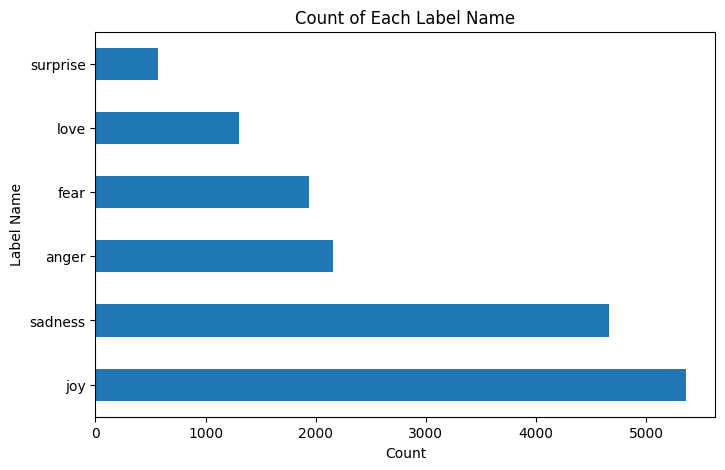

In [11]:
# counts
label_name_counts = df_train['label_name'].value_counts().sort_values(ascending=False)

# Horizontal bar graph
label_name_counts.plot(kind='barh', figsize=(8,5))
plt.title('Count of Each Label Name')
plt.xlabel('Count')
plt.ylabel('Label Name')
plt.show()

In [12]:
# count words per tweet
df_train["Words per tweet"] = df_train['text'].str.split().apply(len)

In [13]:
df_train.head(2)

,text,label,label_name,Words per tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21


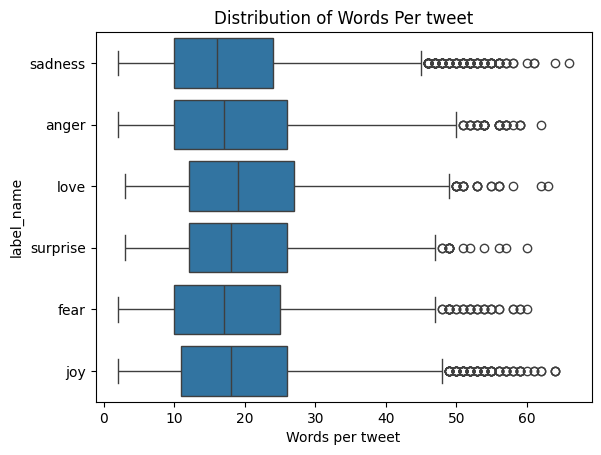

In [14]:
# box plot showing distribution of words in the dataset
sns.boxplot(data=df_train, y='label_name', x ='Words per tweet')
plt.title("Distribution of Words Per tweet")
plt.show()

## Loading the Model

In [15]:
model_checkpoint = 'distilbert/distilbert-base-uncased'

## Tokenization

In [16]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [17]:
text = 'I am finetuning a transformer model'
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 1045, 2572, 2986, 8525, 5582, 1037, 10938, 2121, 2944, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [18]:
emotions_dataset.reset_format()

In [19]:
def tokenizing(batch):
  temp = tokenizer(batch['text'], padding=True, truncation=True)
  return temp

In [20]:
# tonizing the train data
tokenizing(emotions_dataset['train'][:1])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1]]}

In [21]:
# tokenizing train, eval and test datasets
emotions_encoded = emotions_dataset.map(tokenizing, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [22]:
emotions_encoded, emotions_dataset

(DatasetDict({
     train: Dataset({
         features: ['text', 'label', 'input_ids', 'attention_mask'],
         num_rows: 16000
     })
     validation: Dataset({
         features: ['text', 'label', 'input_ids', 'attention_mask'],
         num_rows: 2000
     })
     test: Dataset({
         features: ['text', 'label', 'input_ids', 'attention_mask'],
         num_rows: 2000
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['text', 'label'],
         num_rows: 16000
     })
     validation: Dataset({
         features: ['text', 'label'],
         num_rows: 2000
     })
     test: Dataset({
         features: ['text', 'label'],
         num_rows: 2000
     })
 }))

## Fine Tuning Process

In [23]:
num_labels = len(classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# loading model, adding output
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Training Arguments
batch_size = 62
model_name = 'distiled-bert-finedtuned-emotions'

training_args = TrainingArguments(
    output_dir = model_name,
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 2,
    weight_decay = 0.01,
    eval_strategy = 'epoch',
    disable_tqdm = False
)

In [25]:
# Evaluates how well the model is performing after every epoch
def compute_metrics(pred):
  labels = pred.label_ids  # true labels
  preds = pred.predictions.argmax(-1) # predicted labels, retruns index of the highest score
  f1 = f1_score(labels, preds, average = 'weighted')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'f1': f1}

In [26]:
# Model trainer
trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = emotions_encoded['train'],
    eval_dataset = emotions_encoded['validation'],
    tokenizer = tokenizer
)

In [27]:
# Training the Model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: atimangovictoria775 (atimangovictoria775-pezesha) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.288628,0.914000,0.913730
2,0.518600,0.199783,0.930500,0.930380


TrainOutput(global_step=518, training_loss=0.5077840186454154, metrics={'train_runtime': 521.9428, 'train_samples_per_second': 61.309, 'train_steps_per_second': 0.992, 'total_flos': 720342861696000.0, 'train_loss': 0.5077840186454154, 'epoch': 2.0})

## Evaluating Model Performance

In [35]:
# Extract eval_loss and eval_accuracy from logs
eval_losses = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
eval_accuracies = [log['eval_accuracy'] for log in trainer.state.log_history if 'eval_accuracy' in log]

print(eval_losses)
print(eval_accuracies)


[0.2886279225349426, 0.19978348910808563]
[0.914, 0.9305]


In [36]:
preds_outputs = trainer.predict(emotions_encoded['test'])
preds_outputs.metrics

{'test_loss': 0.20659556984901428,
 'test_accuracy': 0.919,
 'test_f1': 0.9187908371978162,
 'test_runtime': 4.0945,
 'test_samples_per_second': 488.46,
 'test_steps_per_second': 8.06}

In [40]:
y_predicted_labels = np.argmax(preds_outputs.predictions, axis=1)

In [42]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [44]:
y_true_labels = emotions_encoded['test'][:]['label']

In [46]:
print(y_predicted_labels[:5])
print(y_true_labels[:5])

[0 0 0 1 0]
[0, 0, 0, 1, 0]


In [52]:
print(classes)
print()

# Classification Report
cr = classification_report(y_true_labels, y_predicted_labels)
print(cr)

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       581
           1       0.94      0.94      0.94       695
           2       0.78      0.82      0.80       159
           3       0.93      0.92      0.93       275
           4       0.89      0.88      0.89       224
           5       0.78      0.68      0.73        66

    accuracy                           0.92      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.92      0.92      0.92      2000



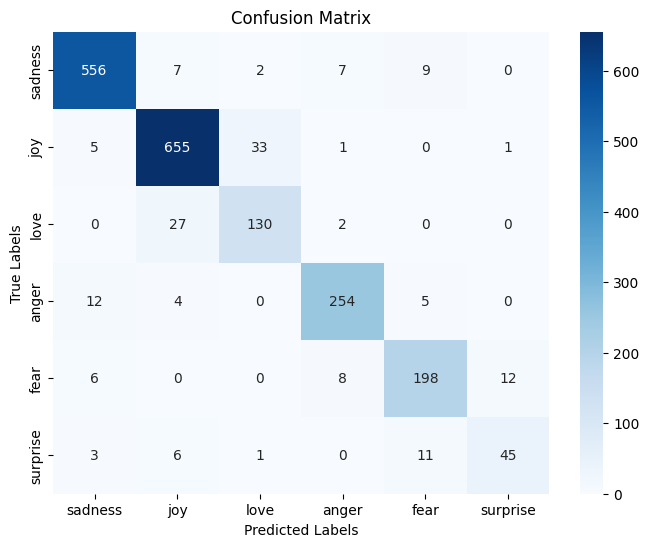

In [53]:
# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_predicted_labels)

# Visulizing
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [54]:
def predict_emotion(text):
  # tokenize input
  inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)

  # Send inputs to same device as model
  inputs = {k: v.to(model.device) for k, v in inputs.items()}

  # Get raw logits from the model
  with torch.no_grad():
      outputs = model(**inputs)

  logits = outputs.logits  # Extracts logits from the ouput

  predicted_index = np.argmax(logits.cpu().numpy(), axis=1)[0] # moves logits to cpu, converts it to numpy array, returns index with highest score

  return classes[predicted_index]

In [58]:
predict_emotion("She surprised me with a birthday party I didn’t expect!")

'surprise'

In [59]:
test_sentences = [
    "I can't stop thinking about how everything could go wrong.",
    "I feel completely drained even though nothing major happened today.",
    "There's a strange calmness in me even though I know I should be worried.",
    "I'm happy for my friend, but I can't help feeling a little jealous too.",
    "I feel a deep sense of peace after confronting my fears.",
    "I'm frustrated because I know I can do better, but something holds me back.",
    "I’m excited about the opportunity, but the pressure is overwhelming.",
    "I feel guilty for being happy while others are suffering.",
    "I miss how things used to be — there’s a constant ache in my chest.",
    "Even in a room full of people, I feel invisible."
]

In [61]:
# predictions on text sentences
for sentence in test_sentences:
  prediction = predict_emotion(sentence)
  print(f"Sentence: {sentence}\nPredicted Emotion: {prediction}\n")

Sentence: I can't stop thinking about how everything could go wrong.
Predicted Emotion: sadness

Sentence: I feel completely drained even though nothing major happened today.
Predicted Emotion: sadness

Sentence: There's a strange calmness in me even though I know I should be worried.
Predicted Emotion: fear

Sentence: I'm happy for my friend, but I can't help feeling a little jealous too.
Predicted Emotion: anger

Sentence: I feel a deep sense of peace after confronting my fears.
Predicted Emotion: joy

Sentence: I'm frustrated because I know I can do better, but something holds me back.
Predicted Emotion: anger

Sentence: I’m excited about the opportunity, but the pressure is overwhelming.
Predicted Emotion: joy

Sentence: I feel guilty for being happy while others are suffering.
Predicted Emotion: sadness

Sentence: I miss how things used to be — there’s a constant ache in my chest.
Predicted Emotion: sadness

Sentence: Even in a room full of people, I feel invisible.
Predicted Emot